In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import torchvision

import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torchmetrics

In [2]:
batch_size = 60

train_dataset = datasets.MNIST(root="dataset/", download=True, train=True, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root="dataset/", download=True, train=False, transform=transforms.ToTensor())

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.72MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.98MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.62MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.0MB/s]


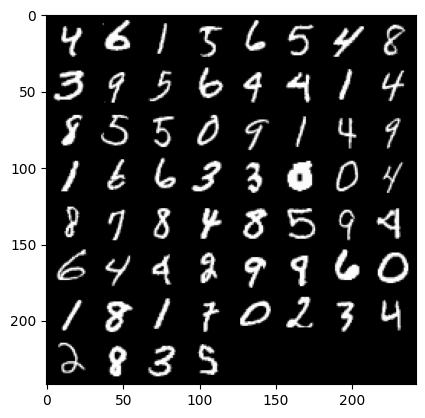

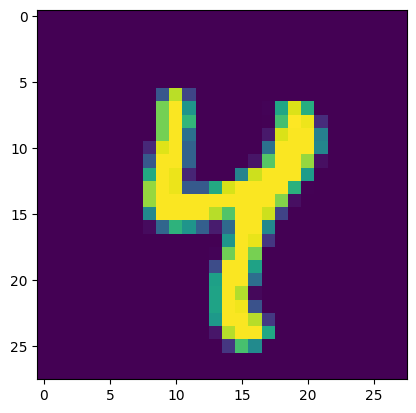

In [5]:
def imshow(img):
   npimg = img.numpy()
   plt.imshow(np.transpose(npimg, (1, 2, 0)))
   plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
labels
# show images
imshow(torchvision.utils.make_grid(images))
imshow(images[0])


In [7]:
class CNN(nn.Module):
   def __init__(self, in_channels, num_classes):

       """
       Building blocks of convolutional neural network.

       Parameters:
           * in_channels: Number of channels in the input image (for grayscale images, 1)
           * num_classes: Number of classes to predict. In our problem, 10 (i.e digits from  0 to 9).
       """
       super(CNN, self).__init__()

       # 1st convolutional layer
       self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, padding=1)
       # Max pooling layer
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
       # 2nd convolutional layer
       self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
       # Fully connected layer
       self.fc1 = nn.Linear(16 * 7 * 7, num_classes)

   def forward(self, x):
       """
       Define the forward pass of the neural network.

       Parameters:
           x: Input tensor.

       Returns:
           torch.Tensor
               The output tensor after passing through the network.
       """
       x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = x.reshape(x.shape[0], -1)  # Flatten the tensor
       x = self.fc1(x)            # Apply fully connected layer
       return x

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNN(in_channels=1, num_classes=10).to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)


In [9]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
num_epochs=10
for epoch in range(num_epochs):
 # Iterate over training batches
   print(f"Epoch [{epoch + 1}/{num_epochs}]")

   for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
       data = data.to(device)
       targets = targets.to(device)
       scores = model(data)
       loss = criterion(scores, targets)
       optimizer.zero_grad()
       loss.backward()
       optimizer.step()

Epoch [1/10]


100%|██████████| 1000/1000 [00:11<00:00, 90.18it/s]


Epoch [2/10]


100%|██████████| 1000/1000 [00:14<00:00, 70.63it/s]


Epoch [3/10]


100%|██████████| 1000/1000 [00:14<00:00, 70.54it/s]


Epoch [4/10]


100%|██████████| 1000/1000 [00:13<00:00, 76.03it/s]


Epoch [5/10]


100%|██████████| 1000/1000 [00:12<00:00, 77.09it/s]


Epoch [6/10]


100%|██████████| 1000/1000 [00:12<00:00, 82.19it/s]


Epoch [7/10]


100%|██████████| 1000/1000 [00:12<00:00, 82.10it/s]


Epoch [8/10]


100%|██████████| 1000/1000 [00:11<00:00, 89.94it/s]


Epoch [9/10]


100%|██████████| 1000/1000 [00:13<00:00, 72.08it/s]


Epoch [10/10]


100%|██████████| 1000/1000 [00:14<00:00, 68.83it/s]


In [12]:
# Set up of multiclass metrics
acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
precision = torchmetrics.Precision(task="multiclass", num_classes=10)
recall = torchmetrics.Recall(task="multiclass", num_classes=10)

# Iterate over the dataset batches
model.eval()
with torch.no_grad():
   for images, labels in test_loader:
       # Get predicted probabilities for test data batch
       outputs = model(images)
       _, preds = torch.max(outputs, 1)
       acc(preds, labels)
       precision(preds, labels)
       recall(preds, labels)

# Compute total test metrics
test_accuracy = acc.compute()
test_precision = precision.compute()
test_recall = recall.compute()

print(f"Test accuracy: {test_accuracy}")
print(f"Test precision: {test_precision}")
print(f"Test recall: {test_recall}")

Test accuracy: 0.9872000217437744
Test precision: 0.9872000217437744
Test recall: 0.9872000217437744
